# Citi Bike Analysis of Station Prediction
So far I have built an ARIMA model with parameters optimized for the total system's output. I'll now implement those parameters for all of the stations in the system. I expect the results to vary dramatically, as the mean and variance amount of rides per day, by station, has been shown to differ greatly. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
# For time series analysis
from statsmodels.tsa import stattools

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Wrangling in one Step
# Specify columns to use
columns = ['bikeid', 'birth year', 'end station id', 
           'end station latitude', 'end station longitude', 'end station name',
           'gender', 'start station id', 'start station latitude', 'start station longitude',
           'start station name', 'starttime', 'stoptime', 'tripduration', 'usertype']

# use your path
path = r'/Users/vincent_zaballa/Springboard_Assignments/capstone_proj_2/CITI_BIKE/2016_data' 
all_files = glob.glob(os.path.join(path, "*.csv"))

# Appending all imported dataframes to empty df
frame = pd.DataFrame()
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_, index_col=None, header=0)
    list_.append(df)
bike_df = pd.concat(list_)

# Naming columns for future use
bike_df.columns = columns + bike_df.columns[15:].tolist()

# Creating left and right dfs
right_df = bike_df[bike_df.iloc[:,0].notnull() == False]
left_df = bike_df[bike_df.iloc[:,0].notnull() == True]
right_df = right_df.dropna(axis=1, how='all')
left_df = left_df.dropna(axis=1, how='all')

# Convert individual dfs' timestamps
# Need to convert two different format dfs to timestamp beforehand to speed things up MASSIVELY
right_df.starttime = pd.to_datetime(right_df.starttime, format='%m/%d/%Y %H:%M:%S')
right_df.stoptime = pd.to_datetime(right_df.stoptime, format='%m/%d/%Y %H:%M:%S')
left_df.starttime = pd.to_datetime(left_df.starttime, format='%Y-%m-%d %H:%M:%S')
left_df.stoptime = pd.to_datetime(left_df.stoptime, format='%Y-%m-%d %H:%M:%S')

# Combining
frames = [right_df, left_df]
bike_df = pd.concat(frames, axis=0)

# Setting starttime as the index
bike_df.index = bike_df['starttime']
bike_df = bike_df.sort_index()

# Fixing Null Values
# Setting NaN values equal to average age
bike_df[bike_df['birth year'].notnull() == False] = np.ceil(bike_df['birth year'].mean()).astype(int)

# Converting the whole column to int to save space
bike_df.loc[:,'birth year'] = bike_df['birth year'].copy().astype(int)
bike_df.loc[:,'tripduration'] = bike_df['tripduration'].copy().astype(int)
bike_df.loc[:,'end station id'] = bike_df['end station id'].copy().astype(int)
bike_df.loc[:,'start station id'] = bike_df['start station id'].copy().astype(int)
bike_df.loc[:,'gender'] = bike_df['gender'].copy().astype(int)
bike_df.loc[:,'bikeid'] = bike_df['bikeid'].copy().astype(int)

# Create a one-time user gender class (unknown) instead of "Other" class
bike_df.loc[:,'gender'].loc[bike_df['usertype'] == 'Customer'] = 3

# Fixing a station's lat/lon
bike_df.loc[:, 'end station latitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = 40.75903008
bike_df.loc[:, 'end station longitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = -73.9938587

# Deleting anomalous (no data) station
bike_df = bike_df[bike_df['end station name'] != 'SSP - Basement']

# Removing the missing start station lat/lons
bike_df = bike_df[bike_df['start station longitude'] != 0]

# Creating distance travelled
# Distance travelled - vectorized
bike_df['LAT_start_rad'], bike_df['LON_start_rad'] = np.radians(bike_df['start station latitude']), np.radians(bike_df['start station longitude'])
bike_df['LAT_end_rad'], bike_df['LON_end_rad'] = np.radians(bike_df['end station latitude']), np.radians(bike_df['end station longitude'])
bike_df['dLON'] = bike_df['LON_end_rad'] - bike_df['LON_start_rad']
bike_df['dLAT'] = bike_df['LAT_end_rad'] - bike_df['LAT_start_rad']
bike_df['distance_miles'] = 3961 * 2 * np.arcsin(np.sqrt(
    np.sin(bike_df['dLAT']/2)**2 + np.cos(bike_df['LAT_start_rad']) * np.cos(bike_df['LAT_end_rad']) * np.sin(bike_df['dLON']/2)**2
))
del bike_df['LON_start_rad'], bike_df['LAT_start_rad'], bike_df['LAT_end_rad'], bike_df['LON_end_rad'], bike_df['dLON'], bike_df['dLAT']


# Average velocity - Assuming they went in a straight line and were moving the entire time...
bike_df['speed_miles/hour'] = bike_df['distance_miles'] / (bike_df['tripduration']/3600)

# deleting max speed data error (trip duration way too long)
bike_df = bike_df.loc[bike_df['speed_miles/hour'] != bike_df['speed_miles/hour'].max()]

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Applying Optimal ARIMA Parameters
We know that the optimal ARIMA parameters for the system were (4,2,2). I can apply that to all of the Citi Bike Stations. I'll collect and aggregate the number of bikes leaving a station by day, apply the ARIMA model parameters to the stations, and evaluate the RMSE for all stations.

In [3]:
# Sort the mean number of bikes leaving per day by station
bike_df['date'] = bike_df.index.date
start_station_df = bike_df.groupby(['date', 'start station id']).size()
start_station_df = start_station_df.reset_index('start station id')
start_station_df = start_station_df.rename(columns={0: "rides_leaving"})
start_station_df.head()

,start station id,rides_leaving
date,,
2016-01-01,72,19
2016-01-01,79,15
2016-01-01,82,10
2016-01-01,83,14
2016-01-01,116,39


In [4]:
len(start_station_df['start station id'].unique())

650

We can see that there are 650 unique stations in the dataset. So, I'll need to go through each unique station, for each day, and compute the RMSE for each station's output with the (4,2,2) ARIMA model and its actual output. First, I need to make a pivot table of the stations, rides, and dates.

In [5]:
start_station_pivot = start_station_df.pivot_table(values='rides_leaving', index='date', columns='start station id')
start_station_pivot = start_station_pivot.dropna(axis=1, thresh=250) #threshold of at least 250 non-nan values
start_station_pivot = start_station_pivot.fillna(value=0).astype(int)
start_station_pivot.head()

start station id,72,79,82,83,116,119,120,127,128,137,...,3235,3236,3237,3238,3241,3242,3243,3244,3246,3249
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,19,15,10,14,39,2,4,20,43,4,...,5,0,2,19,1,3,0,0,0,0
2016-01-02,26,19,17,15,56,0,13,41,42,19,...,7,0,2,14,2,6,0,0,0,0
2016-01-03,17,29,14,24,58,2,12,60,54,12,...,12,0,3,7,6,15,4,0,0,0
2016-01-04,51,36,16,10,92,3,8,118,86,51,...,67,123,0,5,3,8,9,0,0,0
2016-01-05,46,27,17,17,93,4,6,79,70,46,...,47,38,1,16,2,5,8,0,0,0


In [6]:
start_station_pivot.index = pd.to_datetime(start_station_pivot.index)

From the demand station pivot table, we saw that there are many stations that do not have any values for the first part of the year. From the data story, we know that some stations opened beginning of September or late August of the year. Since those stations won't have enough samples to train a model on, I removed them before applying ARIMA models to all of the stations. The criteria for removal was that the station needed to have at least **250** values in order for me to use the station for ARIMA modeling.

## Applying ARIMA Models to Individual Stations
I will now apply the (4,2,2) ARIMA model to all of the stations. I will measure the RMSE for the prediction and provide an analysis of the distribution of RMSE, which stations performed best, and why.

In [7]:
start_station_pivot.columns

Int64Index([  72,   79,   82,   83,  116,  119,  120,  127,  128,  137,
            ...
            3235, 3236, 3237, 3238, 3241, 3242, 3243, 3244, 3246, 3249],
           dtype='int64', name='start station id', length=457)

In [26]:
# Applying ARIMA to all stations
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse


def ARIMA_fitter(df, arima_order):
    '''
    Function takes a dataframe with an index that has a datetime index with a normalized frequency,
    columns that represent equivalent features, and the (p,d,q) order for the ARIMA model.
    
    The function will return a list of RMSE values that correspond to the order of the columns provided
    by the df input. Future edits may make this a dictionary instead of a list.
    '''
    RMSE_list = []
    col_list = []
    for col in df.columns:
        X = df.loc[:,col].values.astype(float)
        best_score = float("inf")
        print('Evaluating station:', col)
        
        try:
            rmse = evaluate_arima_model(X, arima_order)
            if rmse < best_score:
                best_score = rmse
                col_list.append(col)
                RMSE_list.append(best_score)
            print('ARIMA RMSE=%.3f'  % (rmse))
        except:
            print('ARIMA Model could not converge')
            continue
        
        
    return dict(zip(col_list, RMSE_list))

In [9]:
import warnings
warnings.filterwarnings("ignore")
# ignore warnings, as things are about to get messy
ARIMA_fitter(start_station_pivot, (4,2,2))

Evaluating station: 72
ARIMA Model could not converge
Evaluating station: 79
ARIMA RMSE=22.128
Evaluating station: 82
ARIMA Model could not converge
Evaluating station: 83
ARIMA Model could not converge
Evaluating station: 116
ARIMA Model could not converge
Evaluating station: 119
ARIMA Model could not converge
Evaluating station: 120
ARIMA Model could not converge
Evaluating station: 127
ARIMA RMSE=53.597
Evaluating station: 128
ARIMA Model could not converge
Evaluating station: 137
ARIMA RMSE=24.419
Evaluating station: 143
ARIMA Model could not converge
Evaluating station: 144
ARIMA Model could not converge
Evaluating station: 146
ARIMA RMSE=20.738
Evaluating station: 147
ARIMA RMSE=36.287
Evaluating station: 150
ARIMA Model could not converge
Evaluating station: 151
ARIMA Model could not converge
Evaluating station: 152
ARIMA Model could not converge
Evaluating station: 153
ARIMA Model could not converge
Evaluating station: 157
ARIMA Model could not converge
Evaluating station: 161


ARIMA Model could not converge
Evaluating station: 392
ARIMA RMSE=20.176
Evaluating station: 393
ARIMA Model could not converge
Evaluating station: 394
ARIMA Model could not converge
Evaluating station: 395
ARIMA Model could not converge
Evaluating station: 396
ARIMA Model could not converge
Evaluating station: 397
ARIMA Model could not converge
Evaluating station: 398
ARIMA Model could not converge
Evaluating station: 399
ARIMA Model could not converge
Evaluating station: 400
ARIMA Model could not converge
Evaluating station: 401
ARIMA Model could not converge
Evaluating station: 402
ARIMA RMSE=99.799
Evaluating station: 405
ARIMA Model could not converge
Evaluating station: 406
ARIMA Model could not converge
Evaluating station: 407
ARIMA Model could not converge
Evaluating station: 408
ARIMA Model could not converge
Evaluating station: 409
ARIMA Model could not converge
Evaluating station: 410
ARIMA Model could not converge
Evaluating station: 411
ARIMA Model could not converge
Evalu

ARIMA Model could not converge
Evaluating station: 3055
ARIMA Model could not converge
Evaluating station: 3056
ARIMA Model could not converge
Evaluating station: 3057
ARIMA Model could not converge
Evaluating station: 3058
ARIMA Model could not converge
Evaluating station: 3059
ARIMA Model could not converge
Evaluating station: 3060
ARIMA Model could not converge
Evaluating station: 3061
ARIMA Model could not converge
Evaluating station: 3062
ARIMA Model could not converge
Evaluating station: 3063
ARIMA Model could not converge
Evaluating station: 3064
ARIMA Model could not converge
Evaluating station: 3065
ARIMA Model could not converge
Evaluating station: 3066
ARIMA Model could not converge
Evaluating station: 3067
ARIMA Model could not converge
Evaluating station: 3068
ARIMA Model could not converge
Evaluating station: 3069
ARIMA Model could not converge
Evaluating station: 3070
ARIMA Model could not converge
Evaluating station: 3071
ARIMA Model could not converge
Evaluating statio

[22.127930989952468,
 53.596818283625545,
 24.419090198279278,
 20.738325125001424,
 36.287266921335736,
 43.758683711391377,
 35.017351109998962,
 39.178936015749684,
 17.786338157406639,
 53.503308235558521,
 10.600129222594761,
 15.628203670729812,
 34.793314987871291,
 26.374724179200275,
 21.924699877075813,
 18.376430086018818,
 22.409825336527835,
 56.546061472733726,
 52.7281790141651,
 18.822010561912279,
 31.825359000263855,
 22.031410681798697,
 24.414022208888881,
 25.366998954993747,
 56.95978342838508,
 23.365763598321774,
 25.101930255757186,
 40.31928586300247,
 43.631691735608307,
 30.094101376168442,
 50.912441848213717,
 33.818473241149199,
 22.160047403131657,
 37.629137573122243,
 32.628246605252215,
 123.78926850614623,
 22.623246144021842,
 60.41221251140221,
 31.520504815460409,
 67.580837118176987,
 55.21203372414746,
 20.176406400558765,
 99.799095265005604,
 49.419189446281926,
 70.151832624475162,
 50.153166392489361,
 28.852148646154799,
 27.463787827087518

Great, we now have a distribution of RSME for stations that could converge with ARIMA model parameters (4,2,2). Let's find the average RMSE, the station with the largest error, while still converging, and the station with the smallest error. Additionally, I will look at a station that did not converge to help understand why some stations did not converge. Next time I use this function, I will update it to return a dictionary with the station id and the RMSE for that station.

In [10]:
stations_RMSE = [22.127930989952468,
 53.596818283625545,
 24.419090198279278,
 20.738325125001424,
 36.287266921335736,
 43.758683711391377,
 35.017351109998962,
 39.178936015749684,
 17.786338157406639,
 53.503308235558521,
 10.600129222594761,
 15.628203670729812,
 34.793314987871291,
 26.374724179200275,
 21.924699877075813,
 18.376430086018818,
 22.409825336527835,
 56.546061472733726,
 52.7281790141651,
 18.822010561912279,
 31.825359000263855,
 22.031410681798697,
 24.414022208888881,
 25.366998954993747,
 56.95978342838508,
 23.365763598321774,
 25.101930255757186,
 40.31928586300247,
 43.631691735608307,
 30.094101376168442,
 50.912441848213717,
 33.818473241149199,
 22.160047403131657,
 37.629137573122243,
 32.628246605252215,
 123.78926850614623,
 22.623246144021842,
 60.41221251140221,
 31.520504815460409,
 67.580837118176987,
 55.21203372414746,
 20.176406400558765,
 99.799095265005604,
 49.419189446281926,
 70.151832624475162,
 50.153166392489361,
 28.852148646154799,
 27.463787827087518,
 63.361065570041234,
 53.799464199119114,
 37.249030249046115,
 49.69330582973997,
 39.012715151561729,
 43.895154128680936,
 43.616070581954169,
 61.299667101368648,
 47.463312805438413,
 27.175588467926762,
 49.9612246541895,
 57.730536316016988,
 41.23682615715483,
 64.69322243341486,
 47.859857708984997,
 42.591387416170058,
 87.663416710079701,
 38.681958960392592,
 24.400257984180207,
 39.644055123365355,
 38.922938161411096,
 56.820733992965252,
 35.889001484801476,
 75.577049862086227,
 38.810586741689619,
 42.314979719030141,
 51.904018960637238,
 61.484298064400235,
 25.085588664454797,
 45.837495116297021,
 57.287962134780301,
 56.628033501282843,
 57.831751893900233,
 191.23369570407178,
 104.96423582080294,
 36.707294450361246,
 47.398969244070329,
 33.55655920092893,
 54.297506325523869,
 49.357479677381157,
 21.913926748921725,
 45.55284142056329,
 1935.7729166590968,
 36.770096061239492,
 28.830434989351318,
 40.337176445874,
 21.081996564217224,
 66.777270385188132,
 18.4533828784372,
 40.225038110296595,
 16.173725836294022,
 34.478414344176713,
 41.435465712487826]

In [12]:
np.max(stations_RMSE)

1935.7729166590968

In [13]:
np.min(stations_RMSE)

10.600129222594761

In [14]:
np.mean(stations_RMSE)

62.403673591865761

In [15]:
np.median(stations_RMSE)

40.225038110296595

(array([ 29.,  37.,  27.,   2.,   3.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   10.60012922,    29.8518571 ,    49.10358497,    68.35531285,
           87.60704072,   106.85876859,   126.11049647,   145.36222434,
          164.61395222,   183.86568009,   203.11740797,   222.36913584,
          241.62086371,   260.87259159,   280.12431946,   299.37604734,
          318.62777521,   337.

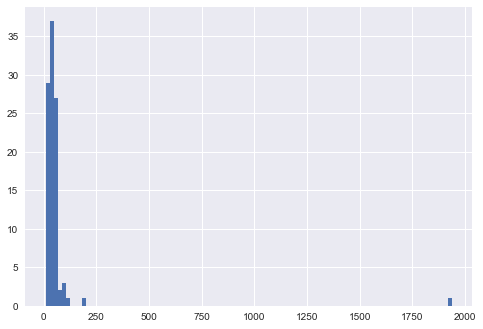

In [19]:
plt.hist(stations_RMSE, bins=100)

In [22]:
station_id_list = [79, 127, 137, 146, 147, 161, 164, 195, 224, 229, 232, 248, 251, 257, 260, 276, 280, 284, 304, 311, 312, 316, 319, 325, 327, 328, 329, 334, 335, 336, 347, 348, 351, 352, 357, 359, 360, 367, 377, 379, 388, 392, 402, 417, 426, 434, 438, 441, 442, 446, 448, 450, 455, 457, 458, 459, 461, 465, 466, 468, 469, 472, 474, 475, 477, 479, 480, 482, 485, 486, 487, 490, 493, 494, 496, 498, 501, 503, 505, 511, 518, 519, 520, 522, 527, 530, 537, 540, 545, 546, 1978, 2012, 2017, 2021, 3119, 3141, 3145, 3156, 3169, 3223, 3224]


In [45]:
station_id_RMSE = dict(zip(station_id_list, stations_RMSE))
# Isolate the columns that converged from the original dataframe
converged_df = start_station_pivot[station_id_list]

In [64]:
# Persistence Model for all the stations that converged
# Create lagged dataset
def station_persistence(df):
    '''
    Takes a df series, shifts, creates a new df, and outputs the results of a persistence model on that df.
    df should have no nan values. This function iterates over all columns, assuming they are of the same
    type and have the same datetime indices. If there are different datetime indices, resampling should be
    done to put them in the same order.
    
    Returns a dictionary with the column name and associated persistence model RMSE.
    '''
    RMSE_list = []
    col_list = []
    for col in df.columns:
        persistence_dataframe = pd.concat([pd.DataFrame(converged_df[col]).shift(), pd.DataFrame(converged_df[col])], axis=1)
        persistence_dataframe.columns = [ 't' ,  't+1' ]

        # split into train and test sets
        X = persistence_dataframe.values
        train_size = int(len(X) * 0.7)
        train, test = X[1:train_size], X[train_size:]
        train_X, train_y = train[:,0], train[:,1]
        test_X, test_y = test[:,0], test[:,1]

        # persistence model
        def model_persistence(x):
            return x
        
        # walk-forward validation
        predictions = list()
        for x in test_X:
            yhat = model_persistence(x)
            predictions.append(yhat)
        rmse = np.sqrt(mean_squared_error(test_y, predictions))
        print('RMSE of persistence model for station %s: %.3f' % (col, rmse))
        RMSE_list.append(rmse)
        col_list.append(col)
    return dict(list(zip(col_list, RMSE_list)))
    

In [65]:
persistence_dict = station_persistence(converged_df)

RMSE of persistence model for station 79: 25.924
RMSE of persistence model for station 127: 65.402
RMSE of persistence model for station 137: 27.337
RMSE of persistence model for station 146: 24.817
RMSE of persistence model for station 147: 43.409
RMSE of persistence model for station 161: 51.458
RMSE of persistence model for station 164: 43.885
RMSE of persistence model for station 195: 49.481
RMSE of persistence model for station 224: 20.757
RMSE of persistence model for station 229: 65.918
RMSE of persistence model for station 232: 12.172
RMSE of persistence model for station 248: 18.767
RMSE of persistence model for station 251: 38.954
RMSE of persistence model for station 257: 31.655
RMSE of persistence model for station 260: 24.222
RMSE of persistence model for station 276: 20.625
RMSE of persistence model for station 280: 27.951
RMSE of persistence model for station 284: 64.613
RMSE of persistence model for station 304: 68.370
RMSE of persistence model for station 311: 21.645
R

We now have the baseline prediction models for both the persistence and the (4,2,2) ARIMA model. We can take the difference and compare how well the station predicted with the RMSE model as opposed to a naive persistence model.

In [70]:
RMSE_diff_dict = {x: persistence_dict[x] - station_id_RMSE[x] for x in station_id_RMSE}
RMSE_diff_dict

{79: 3.7962704477675793,
 127: 11.805605709833479,
 137: 2.9182519408050887,
 146: 4.0786193675213056,
 147: 7.1219233287154324,
 161: 7.6991461775646286,
 164: 8.8672975193463657,
 195: 10.302039848485897,
 224: 2.9704447507717795,
 229: 12.414697546158905,
 232: 1.5721810599555042,
 248: 3.1388375148802776,
 251: 4.1601976494890351,
 257: 5.2799492296955002,
 260: 2.2969448522668934,
 276: 2.2488861473088697,
 280: 5.5408192376155654,
 284: 8.0671135407347094,
 304: 15.641364610264951,
 311: 2.822956223831774,
 312: 4.3776871486269222,
 316: 4.4822174566553095,
 319: 4.7451424007830667,
 325: 3.7786334778126616,
 327: 12.551683515546173,
 328: -1.167532410006153,
 329: -4.5028744298842156,
 334: 8.309715941617803,
 335: 10.528112581520872,
 336: 5.371736948526415,
 347: 10.282239218245714,
 348: 5.1505805831779057,
 351: 5.1808182704313595,
 352: 0.43213605846706571,
 357: 8.1479382053259073,
 359: 47.451829836126407,
 360: 4.7704181606435228,
 367: 16.580221288194757,
 377: 9.683618

After differencing, we see that the vast majority of the stations predict better with an ARIMA model rather than with their corresponding persistence model. This is good to know, as applying a flavor of ARIMA model that is optimized for the system might be a viable solution for the individual substations.

In [79]:
RMSE_diff_dict_df = pd.DataFrame([RMSE_diff_dict])
RMSE_diff_dict_df = RMSE_diff_dict_df.T
RMSE_diff_dict_df.columns = ['RMSE_diff']

In [80]:
RMSE_diff_dict_df.head()

,RMSE_diff
79,3.796270
127,11.805606
137,2.918252
146,4.078619
147,7.121923


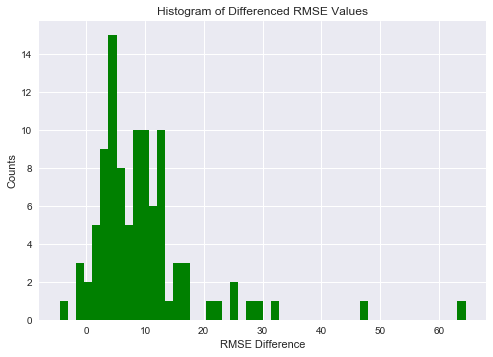

In [92]:
RMSE_diff_dict_df[RMSE_diff_dict_df.RMSE_diff < 200].hist(bins=50, color='g')
plt.xlabel('RMSE Difference')
plt.ylabel('Counts')
plt.title('Histogram of Differenced RMSE Values')

Looking at the histogram of values for the RMSE, we can see that a vast majority are greater than zero. That said, there is a wide distribution of how this model performs with each individual staiton. 

# Applying (4,2,2) ARIMA to Individual Stations Conclusions
I took the optimized ARIMA model for the system-wide stations to predict the number of rides, or demand, at each station within the Citi bike system. Of the originally selected 457 stations that had enough data points to train a model (250 non-NAN points), only 101 of the stations were able to converge upon a solution with the ARIMA model. Of the stations that were able to converge, 97 perfromed better than their baseline persistence model performance for prediction. 

### Pros and Cons of Using ARIMA for Forecasting
Using ARIMA models for forecasting has shown to be a very hands-on forecasting approach that allows the user to understand the nuances of their model. Its rich in the amount of inputs that can be used, and allows for a great amount of feature engineering to be done as a side effect. However, ARIMA models are not very scalable to different, but similar, situations. In this case, I tried using an ARIMA model optimized for the system-wide traffic on the individual, constituent, stations, but many models could not converge upon a solution. This convergence issue is usually due to one of the AR, MA, or I variables not being compatible with the series itself.

This convergence issue also makes sense. If you want to predict the movements of the S&P 500, there are many different parameters to take into account for the S&P 500 than there are for the stocks that make up that exchange.

From this project, I can predict the demand for Citi Bikes on a system-wide scale and for various individual stations. As well, I have demonstrated the limitations that come with this model in modeling for the constituent pieces of the system. My recommendation to NYC or the Citi Bike program is to use this ARIMA model to predict traffic flows on certain days, and to think about how to implement changes that anticipate these increased rates of bicycle traffic within the city.

### Future Work
This project demonstrated the capability of an ARIMA model to predict system-wide traffic for the Citi Bike program. ARIMA models are great for understanding the seasonality of the data, engineering new features, and assessing how the model works in forecasting. In the future, I would use the newly-found features to create a neural network model that would be more robust and scalable to all of the stations in the city. The only issue would be the amount of time required to train all of the models. The combination of using ARIMA to assess system-wide information, use it to engineer new features, and an flexible neural network model could potentially create a prediction model that outperforms a plain and simple ARIMA model.